In [1]:
%matplotlib inline


=============================================================
Receiver Operating Characteristic (ROC) with cross validation
=============================================================

Example of Receiver Operating Characteristic (ROC) metric to evaluate
classifier output quality using cross-validation.

ROC curves typically feature true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This is not very realistic, but it does mean that a larger area under the
curve (AUC) is usually better.

The "steepness" of ROC curves is also important, since it is ideal to maximize
the true positive rate while minimizing the false positive rate.

This example shows the ROC response of different datasets, created from K-fold
cross-validation. Taking all of these curves, it is possible to calculate the
mean area under curve, and see the variance of the curve when the
training set is split into different subsets. This roughly shows how the
classifier output is affected by changes in the training data, and how
different the splits generated by K-fold cross-validation are from one another.

<div class="alert alert-info"><h4>Note</h4><p>See also :func:`sklearn.metrics.auc_score`,
             :func:`sklearn.model_selection.cross_val_score`,
             `sphx_glr_auto_examples_model_selection_plot_roc.py`,</p></div>




In [2]:
print(__doc__)

import string
import numpy as np
import pandas as pd
from scipy import interp
import matplotlib     
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_digits
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords

from pprint import pprint

pd.options.mode.chained_assignment = None

tr = str.maketrans("", "", string.punctuation)

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)


Automatically created module for IPython interactive environment


In [3]:
def get_dataframe(dataframe, train_test = False):
    # dataframe 로드
    df = pd.read_csv(dataframe, encoding = "ISO-8859-1", error_bad_lines = False, engine = 'python')
    # labelled documnent만 가져옴
    if(train_test):
        df_label = df[(df['author'] != '[deleted]') & (df['esre'].notnull()) & (df['selftext'].notnull())]
    else:
         df_label = df[(df['author'] != '[deleted]') & (df['selftext'].notnull())]
    df_label.columns.values
    df_label['fulltext'] = ' ' + df_label.title + '\n ' + df_label.author +'\n ' + df_label.selftext
    #remove punctuation marks
    df_label = df_label[df_label['fulltext'].notnull()]
    df_label['fulltext'] = df_label.fulltext.apply(lambda x: x.translate(tr))
    df_label['tokenized_text'] = df_label.fulltext.apply(lambda x: nltk.word_tokenize(x))
    df_label['tokenized_text'] = df_label.tokenized_text.apply(lambda x: [y.lower() for y in x])
    # tokenizing and stemming post content
    stemmer = SnowballStemmer("english")
    df_label['stemmed_text'] = df_label.tokenized_text.apply(lambda x: [stemmer.stem(y) for y in x])
    df_label['document'] = df_label.stemmed_text.map(lambda x: ' '.join([y for y in x]))
    df_label.reset_index(drop=True,inplace=True)

    if 'esre' in df_label:
        df_label['esre'] = df_label.esre.astype('int')
    return df_label

In [4]:
stopword = pd.read_csv('../Dataset/results/stopword.csv', encoding = "ISO-8859-1")
stopword = stopword[stopword['stopword'] == 1]
stopword = stopword['term'].tolist()
stoplist = stopwords.words('english')
print(len(stoplist))
stoplist.extend(stopword)
print(len(stoplist))

179
1372


In [15]:
# #############################################################################
    # Data IO and generation

    # Import some data to play with

class ROC_Curve():

    
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    def __init__(self, n_split_, tfidf_, classifier_):
        self.cv = StratifiedKFold(n_splits=n_split_)
        self.classifier = classifier_

        self.tfidf = tfidf_
        self.data = get_dataframe('../Dataset/loseit_train/train_5000.csv')
        self.X, self.y = tfidf.fit_transform(self.data.document), self.data.esre
        self.n_samples, self.n_features = self.X.shape
        print(self.X.shape)
        # Add noisy features
#         random_state = np.random.RandomState(0)
#         self.X = np.c_[self.X, random_state.randn(self.n_samples, 10 * self.n_features)]
#         print(self.X.shape)    

    def plot_ROC(self):

        i = 0
        for train, test in self.cv.split(self.X, self.y):
            probas_ = self.classifier.fit(self.X[train], self.y[train]).predict_proba(self.X[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(self.y[test], probas_[:, 1], pos_label = 1)
            self.tprs.append(interp(self.mean_fpr, fpr, tpr))
            self.tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            self.aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                     label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
            i += 1
        plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
                 label='Luck', alpha=.8)

        mean_tpr = np.mean(self.tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(self.mean_fpr, mean_tpr)
        std_auc = np.std(self.aucs)
        plt.plot(self.mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                 lw=4, alpha=.8)

        std_tpr = np.std(self.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(self.mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')
        
        plt.rcParams["figure.figsize"] = [12, 12]
        plt.rcParams["font.family"] = "Times New Roman"
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        
        plt.tick_params(axis='both', which='major', labelsize=20)

        
        csfont = {
            'size'   : 17
        }
        
        plt.xlabel('False Positive Rate', fontsize = 20)
        plt.ylabel('True Positive Rate', fontsize = 20)
        plt.rc('font', **csfont)
        plt.legend(loc="lower right")
        plt.savefig("../Dataset/results/plots/roc.svg", format="svg", transparent=True)
        plt.show()


(5095, 755332)


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


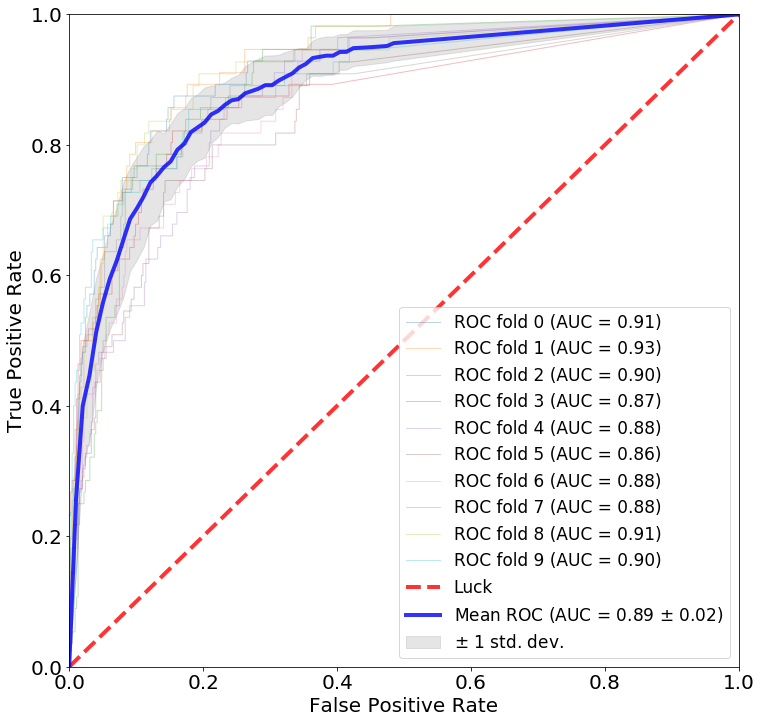

In [16]:
n_split = 10
tfidf = TfidfVectorizer(stop_words=stoplist, 
                        ngram_range = (1, 3)
                       )

clf_sgd_squared_hinge = SGDClassifier(loss='squared_hinge', 
                    penalty='l1', 
                    alpha=0.0001, 
                    max_iter=15, 
                    random_state=42, 
                    shuffle=True
                   )

clf_sgd_modified_huber = SGDClassifier(loss='modified_huber', 
                    penalty='l1', 
                    alpha=0.0001, 
                    max_iter=23, 
                    random_state=42, 
                    shuffle=True
                   )



roc = ROC_Curve(n_split, tfidf, clf_sgd_modified_huber)
roc.plot_ROC()